# Imports and paths

In [1]:
# ROOT PATH
# REPLACE root_path WITH CORRECT ROOT FOLDER PATH
root_path = "C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/"

# path to code base
code_base_path = root_path + "Code/datafi_palindrome_segmentation/"

### RAW DATA NOT USED HERE
# # path to root of raw data files
# raw_data_path = root_path + "Data/"

# path to output folder
output_data_path = root_path + "Output Data - SA/"

In [2]:
### Import standard libraries
import os
# change working directory to the code base folder
os.chdir(path=code_base_path)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import preprocessing

# Import bespoke functions from file (Palindrome Data)
from palindrome_functions import export_tree_diagram, get_tree_code, get_leaf_nodes_info

# Data

### Import dataset and select variables (df)

#### Import processed dataset

In [3]:
df_load = pd.read_csv(output_data_path + "Processed Data/DHS_merged_processed.csv", low_memory=False)

#### Select variables

In [4]:
### EXTRA INFORMATION
admin_vars = [
    ## Geographical
    "district",
    "region",
    # Sample weights etc.
    "dhs_sample_weight",
    "dhs_primary_sampling_unit",
    "dhs_sample_stratum",
    # HIV vars
    "hiv_sample_weight",
    "hiv_result",
    # Health Insurance
    "has_health_insurance",  # health insurance now a post-segmentation descriptor
]

#### FEATURES
# classify vars as ordinal/categorical/numerical
ordinal_features = [
    # values need mapped to integers
    "gender",
    "age_group_2",
    "urban_rural",
    "employed",
    "wealth_bracket",
    "education_attainment",
    # information access
    "used_internet_last_month",
    "watches_tv",
    "listens_radio",
    "reads_newspaper_mag",
    # new context
    "homeowner",
    "has_bank_account",
    "uses_phone_transactions",
    "literacy",
    "sex_of_head",
    "owns_mobile_phone",
    "ever_heard_of_sti",
    "ever_heard_of_aids",
    "had_sti_past_year",
    "ever_hiv_tested",
    "know_place_hiv_test",
    "heard_of_other_sti",
    ### (these tank the count from ~10k to ~7k, together ~5k)
    # "has_health_insurance",  # health insurance now a post-segmentation descriptor
    # "used_condom_last",
    ###
]
categorical_features = [
    # need OneHot
    "ethnicity",
    "marital_status",
]
numeric_features = [
    "n_children_at_home",
    "years_in_residence",
    "age_of_head",
    "age_at_first_sex",
]
feature_vars = ordinal_features + categorical_features + numeric_features

### TARGETS
target_vars = [
    "last_hiv_test_sector",
    "medication_payment",
    # New women-only targets
    "family_planning_last_source_sector",
    "family_planning_first_source_sector",
    "antenatal_care_sector",
    "place_of_delivery_sector",
    "post_birth_check_source_sector",
    "baby_first_check_source_sector",
    # 'baby_fevercough_sector', #TAKE OUT BECAUSE TOO LOW N
    # "dental_care_sector", #TAKE OUT BECAUSE TOO LOW N
    # "sti_advice_sector", #TAKE OUT BECAUSE TOO LOW N
]

In [5]:
# select data + SAMPLE WEIGHTS
chosen_vars = admin_vars + feature_vars + target_vars
df = df_load[chosen_vars].copy()
# print(list(df.columns))

#### Make new composite target: ever_private (ever interacted with private healthcare)

In [6]:
# convert to single variable with "yes", "no" or NaN entries
public_bool = (df[target_vars] == "public").sum(axis=1) > 0
private_bool = (df[target_vars] == "private").sum(axis=1) > 0

df["ever_private"] = np.select(
    [private_bool, public_bool], 
    ["yes", "no"], 
    default="unknown"
)
df["ever_private"].replace({"unknown": np.nan}, inplace=True)
df["ever_private"].value_counts()

no     8644
yes    2093
Name: ever_private, dtype: int64

#### Plot availabilities

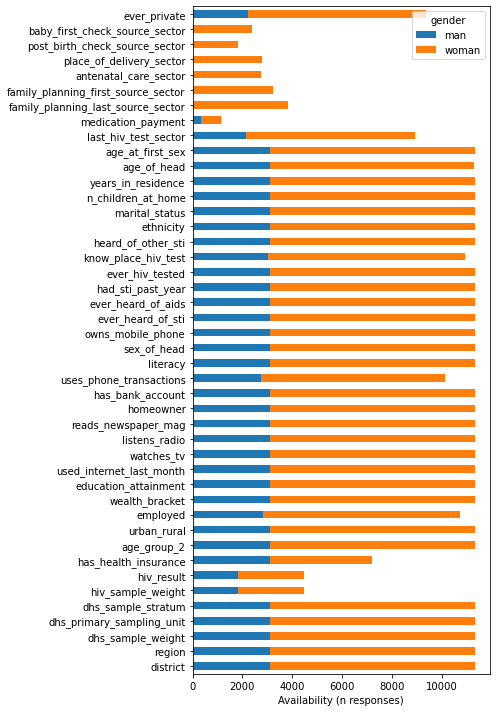

In [7]:
# variable availability
f, ax = plt.subplots(1, 1, figsize=(7, 10))
df.groupby("gender").count().T.plot.barh(stacked=True, ax=ax)

plt.xlabel("Availability (n responses)")
plt.tight_layout()
plt.savefig(output_data_path + "Results/Figures/final_variable_availabilities.png", dpi=300)

### Drop NAs in features (df_clean)

In [8]:
df_clean = df.dropna(subset=feature_vars).copy()
df_clean.shape

(9185, 45)

# Optimal Decision Tree (ML)

## Data prep

### Get final clean dataset

In [9]:
# select data
final_var_list = ["dhs_sample_weight"] + feature_vars + ["ever_private"]

df_select = df_clean
df_select = df_select[final_var_list]
df_select = df_select.dropna()

### Transform dataset to numeric

In [10]:
def transform_features(df_select):

    ### define orders for ordinal categorical variables
    gender_cats = ["man", "woman"]
    age_cats = ["adolescent", "young adult", "adult", "middle-aged"]
    urban_rural_cats = ["rural", "urban"]
    employed_cats = ["unemployed", "employed"]
    wealth_cats = ["poorest", "poorer", "middle", "richer", "richest"]
    education_cats = [
        "no education",
        "incomplete primary",
        "complete primary",
        "incomplete secondary",
        "complete secondary",
        "higher",
    ]
    literacy_cats = [
        "cannot read at all",
        "able to read only parts of sentence",
        "able to read whole sentence",
    ]
    sex_cats = ["male", "female"]
    no_yes_cats = ["no", "yes"]

    # initialise encoder
    # ORDER IS THE SAME AS IN THE "SELECT VARIABLES" CELL AT THE START OF NOTEBOOK
    ordinal_features_encoder = preprocessing.OrdinalEncoder(
        categories=[
            # "gender",
            gender_cats,
            # "age_group_2",
            age_cats,
            # "urban_rural",
            urban_rural_cats,
            # "employed",
            employed_cats,
            # "wealth_bracket",
            wealth_cats,
            # "education_attainment",
            education_cats,
            # "used_internet_last_month",
            no_yes_cats,

            #### NEW information access
            # "watches_tv",
            no_yes_cats,
            # "listens_radio",
            no_yes_cats,
            # "reads_newspaper_mag",
            no_yes_cats,

            #### NEW demographics/contextual
            # "homeowner",
            no_yes_cats,
            # "has_bank_account",
            no_yes_cats,
            # "uses_phone_transactions",
            no_yes_cats,
            # "literacy",
            literacy_cats,
            # "sex_of_head",
            sex_cats,
            # "owns_mobile_phone",
            no_yes_cats,
            # "ever_heard_of_sti",
            no_yes_cats,
            # "ever_heard_of_aids",
            no_yes_cats,
            # "had_sti_past_year",
            no_yes_cats,
            # "ever_hiv_tested",
            no_yes_cats,
            # "know_place_hiv_test",
            no_yes_cats,
            # "heard_of_other_sti",
            no_yes_cats,

            ### (these tank the count from ~10k to ~7k, together ~5k)
            # # "has_health_insurance",  # health insurance now a feature
            # no_yes_cats,
            # # "used_condom_last",
            # no_yes_cats,
            ###
        ]
    )

    X_ordinals_df = df_select[ordinal_features].copy()
    # apply encoder
    X_ordinals = ordinal_features_encoder.fit_transform(X_ordinals_df)
    # put back into dataframe mode
    X_ordinals_df[:] = X_ordinals

    # get numerics
    X_numerics = df_select[numeric_features]

    # OneHot encode categoricals
    # (redundancy kept because we want interpretability at the moment, i.e. drop_first=False)
    X_onehot_categoricals = pd.get_dummies(
        df_select[categorical_features], prefix=categorical_features, drop_first=False
    )

    # make sure everything is an integer
    X_df = X_ordinals_df.join([X_numerics, X_onehot_categoricals]).astype(int)

    # fix names (column names need to be valid Python variable names later)
    X_df.columns = X_df.columns.str.replace(" ", "_")
    X_df.columns = X_df.columns.str.replace("-", "_")
    X_df.columns = X_df.columns.str.replace("/", "_slash_")

    return X_df

In [11]:
X_df = transform_features(df_select)

In [12]:
y = df_select["ever_private"].replace({"no": 0, "yes": 1})
# y = df_select["last_hiv_test_sector"].replace({"public": 0, "private": 1})

In [13]:
sample_weights = df_select["dhs_sample_weight"]

## Model

### Fit Decision Tree

In [14]:
print("No. respondents:", sample_weights.shape[0])
print(
    "Sample weight sum divided by no. respondents:",
    sample_weights.sum() / sample_weights.shape[0],
)
print("Smallest sample weight:", sample_weights.min())
print("Biggest sample weight:", sample_weights.max())

No. respondents: 7905
Sample weight sum divided by no. respondents: 1.0209503666034156
Smallest sample weight: 0.072821
Biggest sample weight: 4.385879


In [15]:
clf = tree.DecisionTreeClassifier(
    # criteria chosen based on:
    # scikit-learn.org/stable/modules/tree.html#complexity

    # (per split) don't split on variable if segment cannot be
    # split into subgroups of high dissimilarity
    min_impurity_decrease=0.0002,

    # minimum final segment (leaf) sample size
    min_weight_fraction_leaf= (235 / len(y))  # equiv. to min ~235 people per leaf, around 0.03% of total sample weights

    # # or for unweighted, use:
    # min_samples_split=200
    # # or
    # min_samples_leaf=200,
)

# fit
clf = clf.fit(X_df, y, sample_weight=sample_weights)

### Export model visualisations

In [16]:
### export tree diagrams
path_to_folder = output_data_path + "Results/Tree Flowchart Diagrams/"
file_prefix = "final_tree_with"

# get diagrams
for rates in [True, False]:
    for format in ["png", "pdf"]:
        export_tree_diagram(
            # graphviz params
            decision_tree=clf,
            feature_names=X_df.columns,
            rates=rates,
            format=format,
            # filesaving params
            path_to_folder=path_to_folder,
            file_prefix=file_prefix,
        )

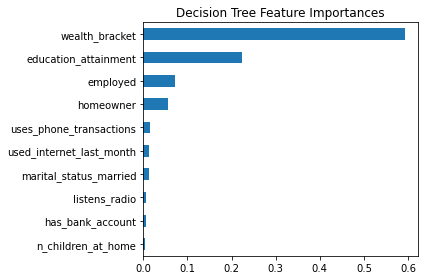

In [17]:
# Get dataframe of feature importances
tree_feature_importance_df = pd.DataFrame({"importance": clf.feature_importances_}, index=X_df.columns)
# sort variable names so onehot encoded ones are adjacent
tree_feature_importance_df.sort_index(inplace=True)
# sort importance values to be able to compare
tree_feature_importance_df.sort_values(by="importance", ascending=True, inplace=True)

# Plot non-zero importances
tree_feature_importance_df.query("importance != 0").plot.barh(legend=False)
plt.title("Decision Tree Feature Importances")
plt.tight_layout()
plt.savefig(output_data_path + "Results/Figures/tree_importances_weighted.png", dpi=300)

# # view
# tree_feature_importance_df.query("importance != 0")

## Get each respondent's segment allocation

### 1. Get tree as useable python code to find each row's segment

In [32]:
# run the bespoke function "get_tree_code and save resulting Python code to file
tree_code = get_tree_code(clf, X_df.columns)
with open(code_base_path + "SA_tree_code_export.py", "w") as f:
    f.write(tree_code)

In [33]:
# import the resulting function into this script
from SA_tree_code_export import get_leaf_node_id
get_leaf_node_id

<function SA_tree_code_export.get_leaf_node_id(X_row)>

### 2. Get each person's segment allocation and save to file alongside cleaned dataset

for maximum coverage use ORIGINAL dataset: select features and drop NAs (NAs in target ignored).

In [20]:
# drop any row that has a missing feature or is missing the sample weight
df_features_clean = df.dropna(subset= feature_vars + ["dhs_sample_weight"])
# only keep features (don't need sample weight)
df_features_clean = df_features_clean[feature_vars]

# transform to numeric so tree can ingest
X_df_all = transform_features(df_features_clean).to_numpy()

# get segment ID that corresponds to each person in this dataset
segment_ids_array = [get_leaf_node_id(x) for x in X_df_all]
segment_ids_all = pd.DataFrame(
    {"segment_id": segment_ids_array},
    index = df_features_clean.index,
)

# add info re. whether person was in training dataset (i.e. with target)
segment_ids_all["in_training_dataset"] = 0
segment_ids_all.loc[df_select.index, "in_training_dataset"] = 1

# # Save just indices and segment allocations to file
# segment_ids_all.to_csv(output_data_path + "Processed Data/segment_allocations_df.csv")

In [21]:
# and add segment ID variable to dataset
df_with_segment_IDs = segment_ids_all.join(df, how="inner")

# save to file
df_with_segment_IDs.to_csv(output_data_path + 'Processed Data/DHS_with_segment_IDs.csv')

## Get leaf node info

In [22]:
df_leaf_info = get_leaf_nodes_info(clf,X_df.columns,['no','yes'])

# get whole sample populations
sample_total_positive = df_leaf_info['n_private'].sum()
sample_total_n = df_leaf_info['n_total'].sum()
# calculate ratios
df_leaf_info['%_segment_ever_private'] = df_leaf_info['n_private']/df_leaf_info['n_total']*100.0
df_leaf_info['pop_%'] = df_leaf_info['n_total']/sample_total_n*100.0

df_leaf_info.to_csv(output_data_path+'Results/Final Summary Stats/leaf_rules_and_target_stats_unweighted.csv')

# Extras
[Under Construction]

## Basic Plots

### Explore target availabilities

In [23]:
def get_weighted_value_rates(variable_name, df=df):
    weighted_value_counts = df.groupby(variable_name)['dhs_sample_weight'].sum().sort_values()

    weighted_total_count = weighted_value_counts.sum()
    weighted_value_rates = weighted_value_counts/weighted_total_count

    return weighted_value_rates

In [24]:
# df[target_vars].dropna(thresh=6)

In [25]:
# before dropping NAs in features
target_counts = df.count()[target_vars+['ever_private']]
percs = [df[target].value_counts().iloc[1]*100 for target in target_vars+['ever_private']] / target_counts

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          8941       11.4
medication_payment                            2497       24.1
family_planning_last_source_sector            3838       16.4
family_planning_first_source_sector           3216       15.7
antenatal_care_sector                         2761        9.2
place_of_delivery_sector                      2788        7.6
post_birth_check_source_sector                1805        7.5
baby_first_check_source_sector                2393        6.3
ever_private                                 10737       19.5

In [26]:
# before dropping NAs in features but with SAMPLE WEIGHTS
target_counts = df.count()[target_vars+['ever_private']]
percs = [get_weighted_value_rates(target, df=df).iloc[0]*100 for target in target_vars+['ever_private']]

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          8941       12.5
medication_payment                            2497       26.7
family_planning_last_source_sector            3838       18.4
family_planning_first_source_sector           3216       17.8
antenatal_care_sector                         2761       11.3
place_of_delivery_sector                      2788        9.3
post_birth_check_source_sector                1805        9.1
baby_first_check_source_sector                2393        7.7
ever_private                                 10737       20.6

In [27]:
# after dropping NAs in features
target_counts = df_clean.count()[target_vars+['ever_private']]
percs = [df_clean[target].value_counts().iloc[1]*100 for target in target_vars+['ever_private']] / target_counts

target_rates_df_clean = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df_clean

n respondents  private_%
last_hiv_test_sector                          7664       11.8
medication_payment                             964       23.4
family_planning_last_source_sector            3286       16.7
family_planning_first_source_sector           2736       16.0
antenatal_care_sector                         2293        9.8
place_of_delivery_sector                      2307        7.9
post_birth_check_source_sector                1509        7.8
baby_first_check_source_sector                1989        6.4
ever_private                                  7905       19.3

In [28]:
# after dropping NAs in features but with SAMPLE WEIGHTS
target_counts = df_clean.count()[target_vars+['ever_private']]
percs = [get_weighted_value_rates(target, df=df_clean).iloc[0]*100 for target in target_vars+['ever_private']]

target_rates_df = pd.DataFrame(
    {"n respondents": target_counts, "private_%": np.round(percs,1)}, 
    index=target_vars+['ever_private']
)

target_rates_df

n respondents  private_%
last_hiv_test_sector                          7664       12.9
medication_payment                             964       27.5
family_planning_last_source_sector            3286       18.4
family_planning_first_source_sector           2736       17.9
antenatal_care_sector                         2293       11.8
place_of_delivery_sector                      2307        9.7
post_birth_check_source_sector                1509        9.3
baby_first_check_source_sector                1989        7.9
ever_private                                  7905       21.2

In [29]:
target_rates_df.to_csv(output_path+'target_availabilities.csv')

NameError: name 'output_path' is not defined

In [ ]:
# df_data_availabilities = pd.DataFrame()

# df_data_availabilities['subset'] = [
#     'Survey*', 
#     'Predictors response', 
#     'HIV test facility response', 
#     'Health insurance response', 
#     'Both targets response']

# df_data_availabilities['count'] = [
#     df.count()['gender'],
#     df_features_clean.count()['gender'],
#     df_no_HI_clean['last_hiv_test_sector'].count(),
#     df_no_tests_clean['has_health_insurance'].count(),
#     df_clean.count()['has_health_insurance']]

# plt.figure(figsize=(5,4))
# ax=sns.barplot(x='subset',y='count',data=df_data_availabilities)

# plt.bar_label(ax.containers[0])
# plt.ylim(0,13000)

# plt.xlabel('')
# plt.ylabel('No. people')
# plt.xticks(rotation=25,ha='right')
# plt.tight_layout()

# plt.savefig(
#     output_path+'Figs/data_availability.png',
#     dpi=300,
#     facecolor='white', transparent=False)

NOTE:
- Possible chance differences in reponses to the health insurance question is because of different samples - check with survey

### Variable Histograms

#### Variable histogram maker function

In [ ]:
def variable_hists_vert(
    data, 
    var_name:str, var_label:str, 
    ordered_values:list, 
    ylim=None,
    file_suffix=None,
    xticks_rotation=None,
    xticks=None,
    **plt_kwargs
    ):

    grid = sns.catplot(
        x=var_name,
        data=data,
        kind='count',
        order=ordered_values,
        **plt_kwargs)

    # add barplot values
    ax = grid.axes[0,0]
    plt.bar_label(ax.containers[0])    
    
    if ylim:
        plt.ylim(0,ylim)
    
    plt.ylabel('No. people')
    plt.xlabel(var_label)
    if xticks_rotation:
        plt.xticks(rotation=xticks_rotation,ha='right')
    if xticks:
        locs, labels = plt.xticks()
        plt.xticks(locs, labels=xticks)

    plt.tight_layout()
    plt.savefig(
        output_path+'Figs/Hists/'+var_name+('_'+file_suffix if file_suffix else '')+'.png',
        dpi=300,
        facecolor='white', transparent=False)

#### Create histograms for all variables

In [ ]:
age_group_2_ordered_values = ["adolescent", "young adult", "adult", "middle-aged"]

In [ ]:
variable_hists_vert(
    df_clean, "age_group_2", "", age_group_2_ordered_values, palette="viridis_r"
)


In [ ]:
variable_hists_vert(
    df_clean, 
    "gender", 
    "", 
    ["man", "woman"], 
    height=4, 
    aspect=0.8, 
    palette="viridis"
)


In [ ]:
variable_hists_vert(
    df_clean,
    "urban_rural",
    "",
    ["urban", "rural"],
    height=4,
    aspect=0.8,
    palette="viridis",
)


In [ ]:
variable_hists_vert(
    df_clean,
    "employed",
    "",
    ["employed", "unemployed"],
    height=4,
    aspect=0.8,
    palette="viridis_r",
)


In [ ]:
occupation_group_ordered_values = [
    "not working",
    "unskilled manual",
    "skilled manual",
    "household and domestic",
    "services",
    "agriculture - unskilled",
    "agricultural - unskilled",
    "agricultural - self employed",
    "agriculture - self employed",
    "clerical",
    "professional/technical/managerial",
]

In [ ]:
var_name = "occupation_group"

sns.catplot(
    y=var_name,
    data=df_clean,
    order=occupation_group_ordered_values,
    kind="count",
    palette="bone",
)

plt.xlabel("No. people")
plt.ylabel("")
plt.tight_layout()
plt.savefig(
    output_path + "Figs/Hists/" + var_name + ".png",
    dpi=300,
    facecolor="white",
    transparent=False,
)


In [ ]:
ordered_wealth_brackets = ["poorest", "poorer", "middle", "richer", "richest"]

In [ ]:
variable_hists_vert(
    df_clean,
    "wealth_bracket",
    "",
    ["poorest", "poorer", "middle", "richer", "richest"],
    palette="viridis_r",
)


In [ ]:
education_attainment_ordered_values = [
    "no education",
    "incomplete primary",
    "complete primary",
    "incomplete secondary",
    "complete secondary",
    "higher",
]

variable_hists_vert(
    df_clean,
    "education_attainment",
    "Education",
    education_attainment_ordered_values,
    xticks_rotation=25,
    palette="viridis_r",
)


In [ ]:
variable_hists_vert(
    df_clean,
    "used_internet_last_month",
    "Used internet last month",
    ["yes", "no"],
    palette="viridis_r",
    height=4,
    aspect=0.8,
)


In [ ]:
ethnicity_values = [
    "black_slash_african",
    "coloured",
    "white",
    "indian_slash_asian",
    "other",
]


In [ ]:
variable_hists_vert(
    df_clean,
    "ethnicity",
    "Ethnicity",
    ethnicity_values,
    # palette='viridis',
    xticks_rotation=20,
    xticks=["black/african", "coloured", "white", "indian/asian", "other"],
)


In [ ]:
variable_hists_vert(
    df_clean, "n_children_at_home", "No. children at home", None, palette="viridis_r"
)


##### Targets

In [ ]:
# var_name = 'last_hiv_test_facility'

# sns.catplot(
#     y=var_name,
#     data=df_clean,
#     kind='count',
#     palette='bone',
#     height=5,
#     aspect=1.5)

# plt.xlabel('No. people')
# plt.ylabel('Last HIV test facility')
# plt.tight_layout()
# plt.savefig(
#     output_path+'Figs/Hists/'+var_name+'.png',
#     dpi=300,
#     facecolor='white', transparent=False)

In [ ]:
variable_hists_vert(
    df_clean,
    "last_hiv_test_sector",
    "Last HIV test sector",
    ["private", "public"],
    height=4,
    aspect=0.8,
)


In [ ]:
# df_clean[(df_clean['last_hiv_test_sector']=='private')&(df_clean['ever_private']=='no')]

In [ ]:
variable_hists_vert(
    df_clean,
    "ever_private",
    "Ever interacted with Private Healthcare",
    ["yes", "no"],
    height=4,
    aspect=0.8,
)


https://seaborn.pydata.org/tutorial/categorical.html

### Correlations with target

#### Target sample average

Last HIV test sector

In [ ]:
# df_select = df_clean[~(df_clean['last_hiv_test_sector']=='unknown')]
df_select = df_clean
# breakdown by private vs public
priv_pub_totals = df_select.groupby("ever_private").count().iloc[:, 0]
priv = priv_pub_totals["yes"]
pub = priv_pub_totals["no"]
# get avg percentage of private goers
avg_priv_perc = priv / (priv + pub) * 100
avg_priv_perc


In [ ]:
df_select.shape[0]

Health Insurance

In [ ]:
# # breakdown by private vs public
# HI_totals = df_select.groupby('has_health_insurance').count().iloc[:,0]
# has_HI = HI_totals['yes']
# no_HI = HI_totals['no']
# # get avg percentage of private goers
# avg_HI_perc = has_HI/(has_HI+no_HI)*100
# avg_HI_perc

In [ ]:
# df_select.dropna().shape[0]

#### Function to automate target-rates barchart creation

In [ ]:
def get_barplot_precentages(
    data,
    x,
    y,
    order=None,
    xlabel="",
    max=50,
    horizontal=None,
    palette="viridis_r",
    figsize=(3, 4),
    savefig=True,
    xticks_rotation=None,
    xticks=None,
):

    # set the necessary variables based on the target selected
    if y == "last_hiv_test_sector":
        pos_value = "private"
        avg_perc = avg_priv_perc
        ylabel = "% private HIV test"

    # elif y=='has_health_insurance':
    #     pos_value = 'yes'
    #     avg_perc = "health insurance avg not found!"
    #     ylabel = '% have health insurance'

    elif y == "ever_private":
        pos_value = "yes"
        avg_perc = avg_priv_perc
        ylabel = "% ever used private healthcare"
    else:
        raise ValueError("Target Unknown")

    # get n people per category
    x_totals = data.groupby(x)[y].count()
    # get break-down by "positive" and "negative" target value
    x_pos_neg_totals = data.groupby(x)[y].value_counts(sort=False)

    # get percentage pos
    df_percs = x_pos_neg_totals / x_totals * 100
    df_percs = df_percs.rename("percentage").reset_index()
    df_percs = df_percs[df_percs[y] == pos_value][[x, "percentage"]]
    df_percs = df_percs.round(1)

    # if horizontal graph, swap variables
    if horizontal == None:
        x_new, y_new = x, "percentage"
    else:
        x_new, y_new = "percentage", x
        xlabel, ylabel = ylabel, xlabel

    # plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        x=x_new,
        y=y_new,
        data=df_percs,
        palette=palette,
        order=(order if order else None),
    )

    # add sample average line and set chart max count
    if horizontal == None:
        plt.axhline(
            avg_perc,
            c="grey",
            ls="--",
            label="Sample Average\n= " + str(np.round(avg_perc, 1)) + "%",
        )
        plt.ylim(0, max)
    else:
        plt.axvline(
            avg_perc,
            c="grey",
            ls="--",
            label="Sample Average\n= " + str(np.round(avg_perc, 1)) + "%",
        )
        plt.xlim(0, max)

    # add bar values
    plt.bar_label(ax.containers[0])

    # rotate xticks or relabel them
    if xticks_rotation:
        plt.xticks(rotation=xticks_rotation, ha="right")
    if xticks:
        locs, labels = plt.xticks()
        plt.xticks(locs, labels=xticks)

    # add legend
    plt.legend()
    # format
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()

    # save to file
    if savefig:
        plt.savefig(output_path + "Figs/Correlations/" + x + "_" + y + ".png", dpi=300)

    # return df_percs

#### Features vs composite target

In [ ]:
get_barplot_precentages(df_select, "gender", "ever_private", max=30, palette="viridis")

In [ ]:
get_barplot_precentages(
    df_select,
    "age_group",
    "ever_private",
    max=50,
    figsize=(5, 5),
    order=age_group_ordered_values,
)


In [ ]:
get_barplot_precentages(
    df_select,
    "age_group_2",
    "ever_private",
    max=30,
    figsize=(5, 5),
    order=age_group_2_ordered_values,
)


In [ ]:
get_barplot_precentages(df_select, "urban_rural", "ever_private", max=50)


In [ ]:
get_barplot_precentages(
    df_select,
    "wealth_bracket",
    "ever_private",
    order=ordered_wealth_brackets,
    figsize=(5, 5),
    max=75,
)


In [ ]:
get_barplot_precentages(
    df_select,
    "occupation_group",
    "last_hiv_test_sector",
    order=occupation_group_ordered_values,
    max=50,
    horizontal=True,
    figsize=(6, 5),
    palette="bone",
)


In [ ]:
get_barplot_precentages(df_select, "employed", "ever_private", max=50)


In [ ]:
get_barplot_precentages(
    df_select,
    "education_attainment",
    "ever_private",
    order=education_attainment_ordered_values,
    figsize=(5, 6),
    max=75,
    xticks_rotation=25,
)


In [ ]:
get_barplot_precentages(
    df_select,
    "used_internet_last_month",
    "ever_private",
    xlabel="Used internet last month",
    max=50,
)


In [ ]:
get_barplot_precentages(
    df_select[df_select["ethnicity"] != "other"],
    "ethnicity",
    "ever_private",
    figsize=(5, 6),
    max=100,
    xticks=["black/african", "coloured", "white", "indian/asian"],
)


In [ ]:
get_barplot_precentages(
    df_select[df_select["n_children_at_home"] < 6],
    "n_children_at_home",
    "ever_private",
    xlabel="No. children at home",
    figsize=(4, 5),
)


## Random Forest (for importances)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(
#     # per split
#     min_impurity_decrease=0.0002,
#     # minimum segment (leaf) population
#     min_weight_fraction_leaf=0.03, # equiv. to ~200 people per leaf

#     random_state=0
#     )
# rf = rf.fit(
#     X_df,
#     y,
#     sample_weight=sample_weights)

In [ ]:
# importances = pd.DataFrame(index=X_df.columns)
# importances['Importance'] = rf.feature_importances_
# importances.sort_values(by='Importance',inplace=True)

In [ ]:
# f,ax = plt.subplots(1,1,figsize=(7,10))
# importances.plot.barh(legend=False,ax=ax)
# plt.xlim(0,1)
# plt.xlabel('Variable Importance')
# plt.tight_layout()
# plt.savefig(
#     output_data_path+'Figs/rf_importances_weighted_new.png',
#     dpi=300,
#     facecolor='white', transparent=False)

In [ ]:
# # Dataset private baseline
# y.mean()

In [ ]:
# # test accuracy on private
# y_test = y[y==1]
# X_test = X_df[y==1]

# rf.score(X_test,y_test)

## Manual Decision Tree

In [ ]:
# df_select = df[~(df['last_hiv_test_sector']=='unknown')]
# df_select = df_select[['last_hiv_test_sector','gender','age_group_2','urban_rural','employed','wealth_bracket']]

In [ ]:
# def get_decision_tree_df(variable_names:list, target_name='last_hiv_test_sector', multi_index=True, rounding=True):
#     # total n people per group
#     people_per_group = df_select.groupby(variable_names)[target_name].count().rename('n')
#     people_per_group = pd.DataFrame(people_per_group)

#     # those people split into private and public
#     priv_pub_per_group = df_select.groupby(variable_names)[target_name].value_counts().rename('n')
#     priv_pub_per_group = pd.DataFrame(priv_pub_per_group)

#     # get priv/public percentage per group
#     priv_pub_ratios = (priv_pub_per_group/people_per_group*100).reset_index()
#     # rename for clarity
#     priv_pub_ratios = priv_pub_ratios.rename({'n':'%_private'},axis=1)

#     # only keep values for the private % and dispose of target column (no longer needed)
#     result_df = priv_pub_ratios[priv_pub_ratios[target_name]=='private'].reset_index(drop=True).drop(target_name,axis=1)

#     # add totals for each group back in
#     result_df['n_total'] = people_per_group.reset_index()['n']

#     if multi_index:
#         result_df = result_df.set_index(variable_names)
#     if rounding:
#         result_df = result_df.round(1)
#     return result_df

In [ ]:
# select_vars = ['gender','urban_rural','employed']
# get_decision_tree_df(select_vars)

In [ ]:
# all_vars = ['gender','age_group_2','urban_rural','employed','wealth_bracket']
# get_decision_tree_df(all_vars)

In [ ]:
# from graphviz import Digraph
# f = Digraph('neato', format='jpg', encoding='utf8', filename='corleone', node_attr={'style': 'filled'},  graph_attr={"concentrate": "true", "splines":"ortho"})
# f.attr('node', shape='box')
# for index, row in df_tree.iterrows():
#   print(row[0])

## Factor cluster visualisation

In [ ]:
# # PCA PLOT CLUSTERS IN SPACE

# import prince

# famd_df = prince.FAMD(n_components=3, n_iter=300).fit_transform(X_df)
# famd_df['segment_ID'] = segment_ids
# famd_df

# # 2D:
# # sns.scatterplot(data=famd_df,x=0,y=1,hue='segment_ID')

# # 3D:
# import plotly.io as pio
# pio.renderers.default = "notebook"
# import plotly.express as px

# fig = px.scatter_3d(
#     famd_df, 
#     x=0, y=1, z=2, 
#     color='segment_ID',
#     # size_max=3, 
#     opacity=0.8
#     )

# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()